In [1]:
import os
import sys
import torch
import requests
from io import BytesIO
import cv2
import numpy as np
import re
import torch
import torch.nn.functional as F
from PIL import Image, ImageFilter
from torchvision import transforms   
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import IntegratedGradients, visualization, TokenReferenceBase, LayerIntegratedGradients
from transformers import AutoProcessor, Gemma3ForConditionalGeneration
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader
from datasets import load_dataset
import torchvision.transforms as transforms


c:\Users\lukas\Desktop\Bachelor_Arbeit\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# -------------------------------------------------------------
# Label-Mapping
# -------------------------------------------------------------
unique_labels = ['yes', 'no']
label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()}

In [4]:
# -------------------------------------------------------------
# Modell und Processor initialisieren
# -------------------------------------------------------------
model_id = "../models/Gemma_3_4B/merged_model_batchsize_2"
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('DEBUG: device', device)
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)
tokenizer = processor.tokenizer
model     = Gemma3ForConditionalGeneration.from_pretrained(model_id, trust_remote_code=True).to(device)
model.eval().zero_grad()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


DEBUG: device cpu


Loading checkpoint shards: 100%|██████████| 9/9 [00:00<00:00, 17.43it/s]


In [5]:
# -------------------------------------------------------------
# Hilfsfunktionen
# -------------------------------------------------------------
def load_image_from_url(image):
    img = Image.open(image).convert("RGB")
    return img
default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#252b36'),
                                                  (1, '#000000')], N=256)

In [6]:
# -------------------------------------------------------------
# Hauptfunktion: Bild‑/Text‑Attribution via Integrated Gradients
# -------------------------------------------------------------
# VQA-Interpretationsfunktion
def vqa_vilt_interpret(image_filename, questions, targets, labels, model, processor, device="cpu"):
    img = load_image_from_url(image_filename)
     # 1) Baseline: verschwommenes Bild, um Bildanteile zu bewerten
    blurred_pil = img.filter(ImageFilter.GaussianBlur(radius=5))
    blur_inputs = processor.apply_chat_template(
        [{"role":"user", "content":[{"type":"image","image":blurred_pil}]}],
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
        padding=True,
        truncation=True,
        do_pan_and_scan=False,
        add_generation_prompt=True
    ).to(device)
    blur_pixel_values = blur_inputs["pixel_values"] 
    img_token_id = processor.tokenizer.image_token_id

    for question, target, label in zip(questions, targets, labels):
        # 2) Prompt mit Originalbild und Frage
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": img},
                    {"type": "text",  "text": question},
                ],
            }
        ]
        inputs = processor.apply_chat_template(
            messages,
            tokenize=True,
            return_dict=True,
            return_tensors="pt",
            padding=True,
            truncation=True,
            do_pan_and_scan=False,
            add_generation_prompt=True
        ).to(device)

        pixel_values    = inputs["pixel_values"]      # [1, 3, H, W]
        input_ids       = inputs["input_ids"]         # [1, seq_len]
        attention_mask  = inputs["attention_mask"]    # [1, seq_len]
        text_embeds     = model.get_input_embeddings()(input_ids)
        pixel_values.requires_grad_(True)
        # Baselines
        pixel_baseline     = blur_pixel_values
        pad_token_id       = processor.tokenizer.pad_token_id
        input_ids_baseline = torch.full_like(input_ids, pad_token_id)
        embeds_baseline    = model.get_input_embeddings()(input_ids_baseline)


        # -----------------------------------------------------
        # Custom Forward – benoetigt von Captum, um Bild und Text
        # gemeinsam abzuleiten
        # -----------------------------------------------------
        def custom_forward(px, txt_emb, _attn):
            # px:      [n_steps, 3, H, W]
            # txt_emb: [n_steps, seq_len, hid]
            n_steps, seq_len, hid = txt_emb.shape
            img_feats = model.get_image_features(px)               # [n_steps, n_patches, hid]
            # Bildplätze ersetzen (<image_soft_token>)
            flat_txt = txt_emb.view(-1, hid)                       # [n_steps*seq_len, hid]
            flat_img = img_feats.view(-1, hid)                     # [n_steps*n_patches, hid]
            mask0    = (input_ids.view(-1) == img_token_id)        # [seq_len]
            mask_all = mask0.repeat(n_steps)                       # [n_steps*seq_len]
            flat_txt[mask_all, :] = flat_img

            embeds = flat_txt.view(n_steps, seq_len, hid)
            attn = attention_mask.repeat(n_steps, 1)               # [n_steps, seq_len]

            outputs = model(
                input_ids=None,
                pixel_values=None,
                inputs_embeds=embeds,
                attention_mask=attn,
                use_cache=False,
            )
            return outputs.logits[:, -1, :]

        # 3) Vorhersage ermitteln
        with torch.no_grad():
            baseline_output = model(
                pixel_values=pixel_values,
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            pred_probs = F.softmax(baseline_output.logits[:, -1, :], dim=-1)
            pred_idx   = pred_probs.argmax(dim=-1)
            pred_ans   = processor.tokenizer.decode([pred_idx.item()]).strip()
            print(f"\nQuestion: {question}")
            print(f"Predicted Answer: {pred_ans}, Target: {target}\n")


        # 4) Integrated Gradients
        ig = IntegratedGradients(custom_forward)
        attributions, delta = ig.attribute(
            inputs=(pixel_values, text_embeds),
            baselines=(pixel_baseline, embeds_baseline),
            additional_forward_args=(attention_mask,),
            target=pred_idx,
            n_steps=300,
            method="riemann_trapezoid",
            internal_batch_size=1,
            return_convergence_delta=True,
        )
        # ---------- Heat-Map vorbereiten ----------
        attr_np = attributions[0].squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
        h_orig, w_orig = img.size[1], img.size[0]      # PIL: .size = (W,H)
        attr_up = cv2.resize(attr_np, (w_orig, h_orig), interpolation=cv2.INTER_LINEAR)
        # ---------- Text‑Attribution ----------
        tokenized = processor.tokenizer.convert_ids_to_tokens(input_ids[0].tolist())
        raw_text_attr = attributions[1].sum(dim=2).squeeze(0).cpu().detach().numpy()

        # Filtern unerwuenschter Tokens
        special_tokens = set(processor.tokenizer.all_special_tokens)
        filtered = []
        for tok, attr in zip(tokenized, raw_text_attr):
            clean = tok.lstrip("▁")
            if re.match(r"^<.*>$", tok):
                continue
            if tok in special_tokens:
                continue
            if clean.lower() in {"user", "model"}:
                continue

            filtered.append((clean, attr))

        if filtered:
            tokens_real, text_attr_real = zip(*filtered)
            text_attr_real = np.array(text_attr_real)
            text_attr_real /= np.linalg.norm(text_attr_real) + 1e-8
        else:
            tokens_real, text_attr_real = [], np.array([])

        tokens_real, text_attr_real = zip(*filtered)
        text_attr_real = np.array(text_attr_real)
        text_attr_real /= np.linalg.norm(text_attr_real) + 1e-8

        # ---------- Visualisierung ----------
        vis_data = [
            visualization.VisualizationDataRecord(
                text_attr_real,
                pred_probs[0][pred_idx].item(),
                pred_ans,
                label,          # True Label
                target,         # Attribution Label
                attributions[1].sum().item(),
                tokens_real,
                0.0,
            )
        ]
        visualization.visualize_text(vis_data)

        # Bild-Attribution
        orig_img = np.asarray(img)
        img_attr = np.transpose(attributions[0].squeeze(0).cpu().detach().numpy(), (1, 2, 0))
        orig_img = np.asarray(img)
        visualization.visualize_image_attr_multiple(
            attr_up, 
            orig_img,
            ["original_image", "heat_map"], ["all", "absolute_value"],
            titles=["Original Image", "Attribution Magnitude"],
            cmap=default_cmap,
            show_colorbar=True,
        )

        # ---------- Attribution‑Summen ----------
        print("Text Contributions: ", attributions[1].sum().item())
        print("Image Contributions:", attributions[0].sum().item())
        print("Total Contribution:", (attributions[0].sum() + attributions[1].sum()).item())


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running on: cuda

Question: do individual myocardial fibres have wavy nuclei?
Predicted Answer: yes, Target: no



True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
no,yes (0.50),no,41.85,do individual myocardial fibres have wavy nuclei ?


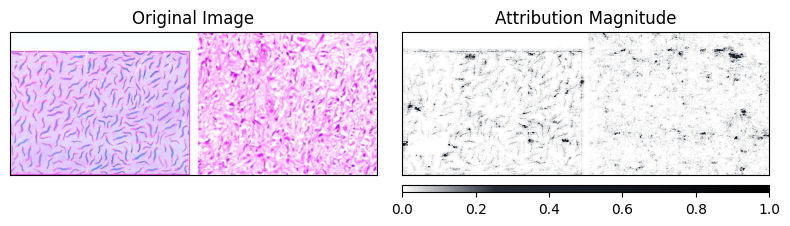

Text Contributions:  41.846343994140625
Image Contributions: -19.452604293823242
Total Contribution: 22.393739700317383


In [ ]:
# -------------------------------------------------------------
# Skripteintrittspunkt
# -------------------------------------------------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Running on:", device)
    #Aufruf
    image_path = "fibrus.PNG"
    questions  = ["do individual myocardial fibres have wavy nuclei?"]
    targets    = ["no"]
    labels     = ["no"]

    vqa_vilt_interpret(
        image_filename=image_path,
        questions=questions,
        targets=targets,
        labels=labels,
        model=model,
        processor=processor,
        device=device,
    )